In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
import numpy as np
import time
import sys
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv('train.csv')
train = train.dropna(how="any").reset_index(drop=True)

train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
# Logistic Regression with sag solver

In [48]:
def getBOW(min_df = 100,ngrams = 1,analyzer = 'word',train = train):
    # bag of letter sequences (chars)
    """
    BOW = TfidfVectorizer(min_df = min_df, analyzer=analyzer, ngram_range=(1,ngrams), lowercase=True)
    """
    
    BOW = CountVectorizer(min_df = min_df, analyzer=analyzer, ngram_range=(1,ngrams), lowercase=True)

    BOW.fit(pd.concat((train['question1'],train['question2'])).unique())
    print('Voabulary size is {}'.format(len(BOW.vocabulary_)))
    return BOW
# word level analyzer
def train_params(min_df = 100,ngrams = 1,analyzer = 'word',train = train):
    start_time = time.time()
    print('BOW and logistic regression')
    BOW = getBOW(min_df=min_df,ngrams = ngrams,analyzer = analyzer)
    trainq1_trans = BOW.transform(train['question1'].values)
    trainq2_trans = BOW.transform(train['question2'].values)
    labels = train['is_duplicate'].values
    X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
    y = labels
    X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)
    model = linear_model.LogisticRegression(n_jobs=4,solver = 'sag',max_iter = 1000)        
    print('fitting ...')
    model.fit(X_train,y_train)
    print('predicting ...')
    y_pred = model.predict(X_valid)
    loss = log_loss(y_valid,y_pred)
    print('log_loss ... {}'.format(loss))
    accuracy = accuracy_score(y_valid,y_pred)
    print('accuracy is ... {}'.format(accuracy))
    auc = roc_auc_score(y_valid,y_pred)
    print('auc is  ... {}'.format(auc))
    #print("log loss is {}".format(loss))
    end_time =time.time()
    print("total time elapsed is {}".format(end_time-start_time))
    return [loss,accuracy,auc]


In [43]:
train_params(min_df = 1000,ngrams = 2,analyzer = 'word',train = train)

BOW and logistic regression
Voabulary size is 871
fitting ...
predicting ...
log_loss ... 9.761222772948106
accuracy is ... 0.717385601319192
auc is  ... 0.6639888566904476
total time elapsed is 778.9370999336243


(9.761222772948106, 0.717385601319192, 0.6639888566904476)

In [51]:
df_arr = [10,100,1000]
ngrams = [1,2,3]
met = np.zeros([3,3,3])
for i,df in enumerate(df_arr):
    for j,ng in enumerate(ngrams):
        print('df {}: ng {}'.format(df,ng))
        met[i,j,:] = train_params(min_df = df,ngrams = ng,analyzer = 'word',train = train)

df 10: ng 1
BOW and logistic regression
Voabulary size is 18596
fitting ...
predicting ...
log_loss ... 8.7342537163125
accuracy is ... 0.7471198890679459
auc is  ... 0.7162732023783892
total time elapsed is 185.00008583068848
df 10: ng 2
BOW and logistic regression
Voabulary size is 76183
fitting ...
predicting ...
log_loss ... 7.960970513044623
accuracy is ... 0.7695086759359893
auc is  ... 0.7453169835323736
total time elapsed is 464.4311978816986
df 10: ng 3
BOW and logistic regression
Voabulary size is 109050
fitting ...
predicting ...
log_loss ... 7.866218863600269
accuracy is ... 0.7722519956526628
auc is  ... 0.7485146917718372
total time elapsed is 524.6094677448273
df 100: ng 1
BOW and logistic regression
Voabulary size is 4412
fitting ...
predicting ...
log_loss ... 9.052929834256808
accuracy is ... 0.737893040512686
auc is  ... 0.698132024781972
total time elapsed is 80.89513683319092
df 100: ng 2
BOW and logistic regression
Voabulary size is 8850
fitting ...
predicting ...

In [52]:
np.save('logistic.npy',met)

In [99]:
def train_params_xgb(min_df = 100,ngrams = 1,analyzer = 'word',train = train):
    start_time = time.time()
    print('BOW and xgb')
    BOW = getBOW(min_df=min_df,ngrams = ngrams,analyzer = analyzer)
    trainq1_trans = BOW.transform(train['question1'].values)
    trainq2_trans = BOW.transform(train['question2'].values)
    labels = train['is_duplicate'].values
    X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
    y = labels
    X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)
    dtrain = xgb.DMatrix(X_train,label = y_train)
    dvalid = xgb.DMatrix(X_valid,label = y_valid)
    param = {'max_depth':50, 'eta':0.3, 'silent':1, 'objective':'binary:logistic','subsample':0.8,'gamma':0 }
    param['nthread'] = 7   
    param['eval_metric'] = 'auc'
    num_round = 100
    evallist  = [(dvalid,'eval'),(dtrain,'train')]
    bst = xgb.train(param, dtrain, num_round, evallist)
    y_pred = bst.predict(dvalid)
    loss = log_loss(y_valid,y_pred)
    print('log_loss ... {}'.format(loss))
    accuracy = accuracy_score(y_valid,np.round(y_pred).astype(int))
    print('accuracy is ... {}'.format(accuracy))
    auc = roc_auc_score(y_valid,y_pred)
    print('auc is  ... {}'.format(auc))
    end_time =time.time()
    print("total time elapsed is {}".format(end_time-start_time))
    return [loss,accuracy,auc]

df_arr = [10,100,1000]
ngrams = [1,2,3]
met_xgb = np.zeros([3,3,3])
for i,df in enumerate(df_arr):
    for j,ng in enumerate(ngrams):
        print('df {}: ng {}'.format(df,ng))
        met_xgb[i,j,:] = train_params_xgb(min_df = df,ngrams = ng,analyzer = 'word',train = train)
np.save('xgb_met.npy',met_xgb)

df 10: ng 1
BOW and xgb
Voabulary size is 18596
[0]	eval-auc:0.768572	train-auc:0.842807
[1]	eval-auc:0.794296	train-auc:0.878154
[2]	eval-auc:0.808848	train-auc:0.901814
[3]	eval-auc:0.81723	train-auc:0.912912
[4]	eval-auc:0.823848	train-auc:0.922459
[5]	eval-auc:0.828458	train-auc:0.929302
[6]	eval-auc:0.833341	train-auc:0.935616
[7]	eval-auc:0.836093	train-auc:0.938497
[8]	eval-auc:0.840059	train-auc:0.943763
[9]	eval-auc:0.842278	train-auc:0.946114
[10]	eval-auc:0.844521	train-auc:0.948072
[11]	eval-auc:0.846698	train-auc:0.950568
[12]	eval-auc:0.848253	train-auc:0.952102
[13]	eval-auc:0.850865	train-auc:0.954386
[14]	eval-auc:0.851951	train-auc:0.955355
[15]	eval-auc:0.853606	train-auc:0.957293
[16]	eval-auc:0.854585	train-auc:0.958166
[17]	eval-auc:0.855402	train-auc:0.958866
[18]	eval-auc:0.856175	train-auc:0.959508
[19]	eval-auc:0.856882	train-auc:0.96029
[20]	eval-auc:0.857735	train-auc:0.961077
[21]	eval-auc:0.858386	train-auc:0.961757
[22]	eval-auc:0.859046	train-auc:0.96236

[91]	eval-auc:0.877426	train-auc:0.978173
[92]	eval-auc:0.877514	train-auc:0.978283
[93]	eval-auc:0.877775	train-auc:0.978477
[94]	eval-auc:0.878029	train-auc:0.978979
[95]	eval-auc:0.878132	train-auc:0.97906
[96]	eval-auc:0.878211	train-auc:0.979117
[97]	eval-auc:0.878325	train-auc:0.979242
[98]	eval-auc:0.878457	train-auc:0.979369
[99]	eval-auc:0.878575	train-auc:0.979434
log_loss ... 0.4153076962885519
accuracy is ... 0.8032754937600719
auc is  ... 0.87857510711082
total time elapsed is 221.93373894691467
df 10: ng 3
BOW and xgb
Voabulary size is 109050
[0]	eval-auc:0.763133	train-auc:0.832278
[1]	eval-auc:0.787737	train-auc:0.865459
[2]	eval-auc:0.802704	train-auc:0.888317
[3]	eval-auc:0.81228	train-auc:0.902367
[4]	eval-auc:0.823464	train-auc:0.918363
[5]	eval-auc:0.828468	train-auc:0.926134
[6]	eval-auc:0.833164	train-auc:0.932091
[7]	eval-auc:0.836173	train-auc:0.9361
[8]	eval-auc:0.838788	train-auc:0.939504
[9]	eval-auc:0.842774	train-auc:0.942676
[10]	eval-auc:0.84475	train-au

[79]	eval-auc:0.877498	train-auc:0.98039
[80]	eval-auc:0.87772	train-auc:0.980678
[81]	eval-auc:0.877794	train-auc:0.980792
[82]	eval-auc:0.878108	train-auc:0.981328
[83]	eval-auc:0.878383	train-auc:0.981484
[84]	eval-auc:0.878507	train-auc:0.9816
[85]	eval-auc:0.878677	train-auc:0.98177
[86]	eval-auc:0.878992	train-auc:0.982106
[87]	eval-auc:0.879116	train-auc:0.98219
[88]	eval-auc:0.879258	train-auc:0.982318
[89]	eval-auc:0.879313	train-auc:0.982415
[90]	eval-auc:0.879393	train-auc:0.982528
[91]	eval-auc:0.879573	train-auc:0.982669
[92]	eval-auc:0.879617	train-auc:0.982732
[93]	eval-auc:0.879773	train-auc:0.982873
[94]	eval-auc:0.879987	train-auc:0.983065
[95]	eval-auc:0.880113	train-auc:0.983161
[96]	eval-auc:0.880215	train-auc:0.983268
[97]	eval-auc:0.880326	train-auc:0.983337
[98]	eval-auc:0.880523	train-auc:0.983466
[99]	eval-auc:0.880661	train-auc:0.983556
log_loss ... 0.4119255146135244
accuracy is ... 0.8050668965258779
auc is  ... 0.8806611036772358
total time elapsed is 114.

[67]	eval-auc:0.874287	train-auc:0.978592
[68]	eval-auc:0.874409	train-auc:0.978686
[69]	eval-auc:0.874526	train-auc:0.978834
[70]	eval-auc:0.874886	train-auc:0.979206
[71]	eval-auc:0.875035	train-auc:0.979317
[72]	eval-auc:0.875196	train-auc:0.979482
[73]	eval-auc:0.875327	train-auc:0.979718
[74]	eval-auc:0.875446	train-auc:0.97982
[75]	eval-auc:0.875708	train-auc:0.979985
[76]	eval-auc:0.875898	train-auc:0.980221
[77]	eval-auc:0.876176	train-auc:0.980484
[78]	eval-auc:0.876259	train-auc:0.980598
[79]	eval-auc:0.87642	train-auc:0.980719
[80]	eval-auc:0.876479	train-auc:0.980824
[81]	eval-auc:0.876608	train-auc:0.980962
[82]	eval-auc:0.876923	train-auc:0.981198
[83]	eval-auc:0.877045	train-auc:0.981299
[84]	eval-auc:0.877107	train-auc:0.981401
[85]	eval-auc:0.877192	train-auc:0.981489
[86]	eval-auc:0.877269	train-auc:0.981576
[87]	eval-auc:0.877348	train-auc:0.981667
[88]	eval-auc:0.877514	train-auc:0.981787
[89]	eval-auc:0.877683	train-auc:0.981938
[90]	eval-auc:0.877804	train-auc:0.9

[55]	eval-auc:0.871811	train-auc:0.986383
[56]	eval-auc:0.871955	train-auc:0.986669
[57]	eval-auc:0.872174	train-auc:0.986872
[58]	eval-auc:0.872355	train-auc:0.987032
[59]	eval-auc:0.872516	train-auc:0.987277
[60]	eval-auc:0.872725	train-auc:0.98752
[61]	eval-auc:0.87295	train-auc:0.987747
[62]	eval-auc:0.873199	train-auc:0.9879
[63]	eval-auc:0.873267	train-auc:0.988072
[64]	eval-auc:0.873448	train-auc:0.988423
[65]	eval-auc:0.873709	train-auc:0.988667
[66]	eval-auc:0.874024	train-auc:0.98895
[67]	eval-auc:0.874246	train-auc:0.989133
[68]	eval-auc:0.874361	train-auc:0.989267
[69]	eval-auc:0.874554	train-auc:0.989455
[70]	eval-auc:0.874673	train-auc:0.989647
[71]	eval-auc:0.87482	train-auc:0.989845
[72]	eval-auc:0.874926	train-auc:0.990023
[73]	eval-auc:0.875164	train-auc:0.99016
[74]	eval-auc:0.875375	train-auc:0.990334
[75]	eval-auc:0.875467	train-auc:0.990519
[76]	eval-auc:0.875578	train-auc:0.990611
[77]	eval-auc:0.875819	train-auc:0.990795
[78]	eval-auc:0.875973	train-auc:0.990905

In [5]:
xgb_met = np.load('xgb_met.npy')

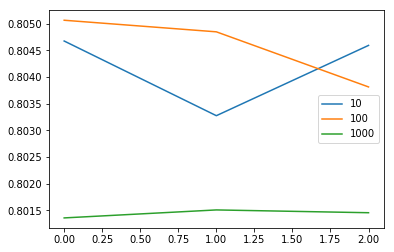

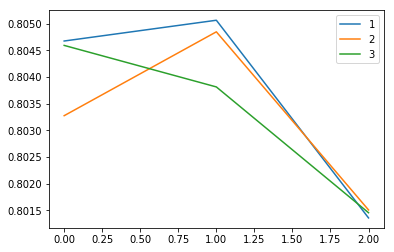

In [20]:
df_arr = [10,100,1000]
ngrams = [1,2,3]
for i in range(3):
    plt.plot(xgb_met[i,:,1],label = df_arr[i])
plt.legend()
plt.show()

for i in range(3):
    plt.plot(xgb_met[:,i,1],label = ngrams[i])
plt.legend()

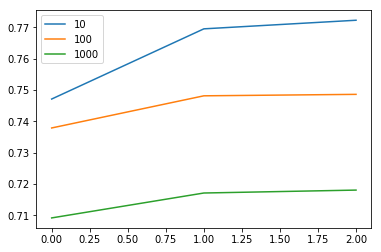

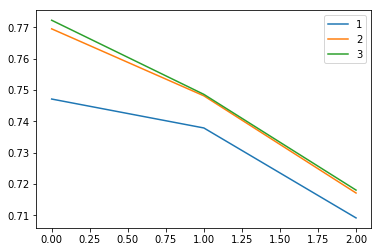

In [25]:
logistic = np.load('logistic.npy')
df_arr = [10,100,1000]
ngrams = [1,2,3]
for i in range(3):
    plt.plot(logistic[i,:,1],label = df_arr[i])
plt.legend()
plt.show()

for i in range(3):
    plt.plot(logistic[:,i,1],label = ngrams[i])
plt.legend()